# Assignment:-


# Applying Decision Tree on Amazon Fine Food Reviews Analysis

 Note:- However Decision tree algorithm does not support missing values.

## Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# 1. Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). Use BoW, TF-IDF, Avg-Word2Vec,TF-IDF-Word2Vec to vectorise the reviews. 
Apply Decision Tree Algorithm for Amazon fine food Reviews
find the optimal depth using cross validation
Get feature importance for positive class and Negative class

In [1]:
# loading required libraries 

import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import gensim
import scipy 
import nltk
import time
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



## 1.1 Connecting SQL file

In [2]:
#Loading the data
con = sqlite3.connect('./final.sqlite')

data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [3]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


## 1.2 Data Preprocessing

In [4]:
data.Score.value_counts()
#i had done data preprocessing i had stored in final.sqlite now loaded this file no need to do again data preprocessing


positive    307061
negative     57110
Name: Score, dtype: int64

## 1.3 Sorting the data

In [5]:
# Sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.4 Mapping

In [6]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative
sorted_data.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.5 Taking First 150k rows

In [7]:
# We will collect different 150000 rows without repetition from time_sorted_data dataframe
my_final = sorted_data[:150000]
print(my_final.shape)
my_final.head()

(150000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.6 Spliting data into train and test based on time (70:30)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


x=my_final['CleanedText'].values
y=my_final['Score']

#Splitting data into train test and cross validation 
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size =0.3,random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(105000,)
(45000,)
(105000,)
(45000,)


## Techniques For Vectorization

## Why we have to convert text to vector
By converting text to vector we can use whole power of linear algebra.we can find a plane to seperate

Bow and tfidf has high dimensions SO it takes more time to compute. so that's the reason am not applying Decision Tree Algorithm to bow,tfidf  

## 2.BOW

In [9]:
#Bow

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() 
final_counts_Bow_tr= count_vect.fit_transform(x_train)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_tr))
print("the shape of out text BOW vectorizer ",final_counts_Bow_tr.get_shape())
print("the number of unique words ", final_counts_Bow_tr.get_shape()[1])
final_counts_Bow_test= count_vect.transform(x_test)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_test))
print("the shape of out text BOW vectorizer ",final_counts_Bow_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (105000, 38300)
the number of unique words  38300
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (45000, 38300)


## 2.1 Normalizing Data


In [10]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_Bow_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_Bow_test)
print(standardized_data_test.shape)


(105000, 38300)
(45000, 38300)


## 2.2.1 Replacing nan values with 0's.


In [11]:
# Replacing nan values with 0's.

standardized_data_train = np.nan_to_num(standardized_data_train)
standardized_data_test = np.nan_to_num(standardized_data_test)

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

param_grid = {'max_depth': [2,3,4,5,6,7,8,9,10,11,12]}
model = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=5,criterion = 'gini',random_state = 100,class_weight ='balanced'), param_grid,scoring ='f1',cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print(model.best_score_, model.best_params_) 
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))

a = model.best_params_
optimal_max_depth = a.get('max_depth')


0.8038940474071021 {'max_depth': 11}
Model with best parameters :
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=11, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')
Accuracy of the model :  0.8075602391806287


In [13]:
results = model.cv_results_
results['mean_test_score']

array([0.52791456, 0.62265711, 0.66464012, 0.66002788, 0.68992465,
       0.72641363, 0.75805165, 0.761803  , 0.79249265, 0.80389405,
       0.80178024])

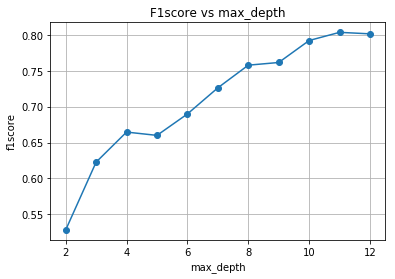

In [14]:
max_depth=2,3,4,5,6,7,8,9,10,11,12
plt.plot(max_depth,results['mean_test_score'],marker='o')
plt.xlabel('max_depth')
plt.ylabel('f1score')
plt.title("F1score vs max_depth")
plt.grid()
plt.show()

## Heatmap for Plotting CV Scores

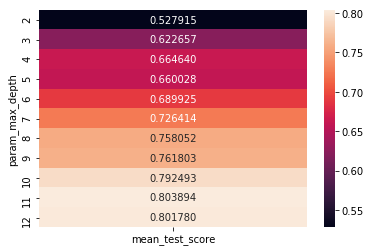

In [15]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score',index='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [16]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth=optimal_max_depth,class_weight ='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 2.3 Confusion Matrix

Confusion Matrix:


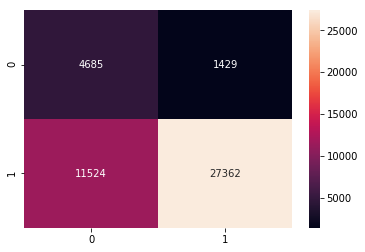

In [17]:
cm_bow=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [18]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4685 
 false positives are 1429 
 false negatives are 11524
 true positives are 27362 
 


## 2.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [19]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# evaluating accuracy
acc_bow = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the Decision tree for maxdepth = %.3f is %f%%' % (optimal_max_depth, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error Decision tree for maxdepth  is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision Decision tree for maxdepth  = %.3f is %f' % (optimal_max_depth, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the Decision tree for maxdepth  = %.3f is %f' % (optimal_max_depth, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the  Decision tree for maxdepth  \n\n ',(classification_report))


The Test Accuracy of the Decision tree for maxdepth = 11.000 is 71.215556%

Test Error Decision tree for maxdepth  is  28.784444%

The Test Precision Decision tree for maxdepth  = 11.000 is 0.950366

The Test Recall of the Decision tree for maxdepth  = 11.000 is 0.703647

The Test classification report of the  Decision tree for maxdepth  

                precision    recall  f1-score   support

           0       0.29      0.77      0.42      6114
           1       0.95      0.70      0.81     38886

   micro avg       0.71      0.71      0.71     45000
   macro avg       0.62      0.73      0.61     45000
weighted avg       0.86      0.71      0.76     45000



## 2.5 Plotting roc_auc curve

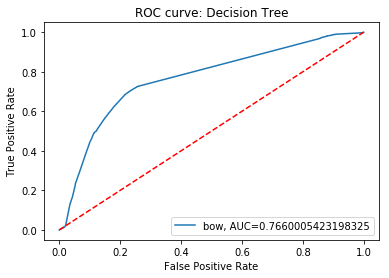

In [20]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="bow, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: Decision Tree')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2.6 Top 25 words 

In [21]:
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_25 = likelihood_df.sort_values(by='Score',ascending=False).iloc[:25]
top_25.reset_index(inplace=True)
top_words = top_25['index']
print(top_words)

0          great
1           love
2           best
3     disappoint
4         delici
5        perfect
6        favorit
7           good
8          excel
9           nice
10           bad
11       thought
12          easi
13          tast
14       terribl
15         worst
16       product
17       horribl
18         would
19      unfortun
20         stale
21         least
22          wont
23         money
24        return
Name: index, dtype: object




Word Cloud for Important features


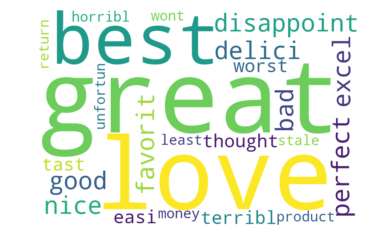

In [22]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(top_words)

wc = WordCloud(background_color="white", max_words=len(top_words), 
               width=900, height=600, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2.7 Visualizing Decision tree By graph


In [30]:
from IPython.display import Image 
from sklearn.tree import export_graphviz
from io import StringIO
from sklearn import tree
import pydotplus
target = ['1','0']
dot_data = StringIO()
export_graphviz(clf,max_depth=3,out_file=dot_data,filled=True,class_names=target,feature_names=count_vect.get_feature_names(),rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# Show graph
Image(graph.create_png())
# Create PNG
graph.write_png("bag of words.png")




True

## 3. TF-IDF

In [31]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()

final_counts_tfidf_tr= tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(final_counts_tfidf_tr))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_tr.get_shape())
print("the number of unique words ", final_counts_tfidf_tr.get_shape()[1])
final_counts_tfidf_test= tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_tfidf_test))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_test.get_shape())
print("the number of unique words ", final_counts_tfidf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (105000, 38300)
the number of unique words  38300
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (45000, 38300)
the number of unique words  38300


## 3.1 Normalizing Data

In [32]:
# Data-preprocessing: Normalizing Data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_test)
print(standardized_data_test.shape)

(105000, 38300)
(45000, 38300)


## 3.2 Replacing nan values with 0's.

In [33]:
standardized_data_train = np.nan_to_num(standardized_data_train)
standardized_data_test = np.nan_to_num(standardized_data_test)

## 3.3 Applying Decision Tree Algorithm

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

param_grid = {'max_depth': [3,4,5,6,7,8,9,10,11]}
model = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=5,criterion = 'gini',random_state = 100,class_weight ='balanced'), param_grid,scoring ='f1',cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print(model.best_score_, model.best_params_) 
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))

a = model.best_params_
optimal_max_depth = a.get('max_depth')

0.7929558292310409 {'max_depth': 11}
Model with best parameters :
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=11, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')
Accuracy of the model :  0.7974550898203593


In [35]:
results = model.cv_results_
results['mean_test_score']

array([0.62716029, 0.66876235, 0.66465578, 0.6923533 , 0.74184638,
       0.76017882, 0.78450084, 0.78165807, 0.79295583])

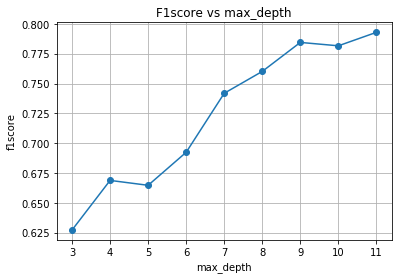

In [36]:
max_depth=3,4,5,6,7,8,9,10,11
plt.plot(max_depth,results['mean_test_score'],marker='o')
plt.xlabel('max_depth')
plt.ylabel('f1score')
plt.title("F1score vs max_depth")
plt.grid()
plt.show()

## Heatmap for Plotting CV Scores

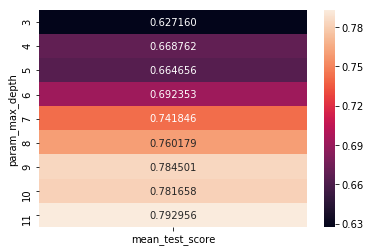

In [37]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score',index='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [38]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth=optimal_max_depth,class_weight ='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 3.4 Confusion Matrix

Confusion Matrix:


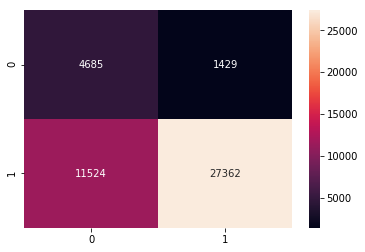

In [39]:
cm_tfidf=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [40]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4824 
 false positives are 1290 
 false negatives are 12195
 true positives are 26691 
 


## 3.5 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [41]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the Decision tree for maxdepth = %.3f is %f%%' % (optimal_max_depth, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error of the Decision tree for maxdepth  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the Decision tree for maxdepth is = %.3f is %f' % (optimal_max_depth, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the Decision tree for maxdepth is = %.3f is %f' % (optimal_max_depth, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the Decision tree for maxdepth is \n\n ',(classification_report))


The Test Accuracy of the Decision tree for maxdepth = 11.000 is 70.033333%

Test Error of the Decision tree for maxdepth  29.966667%

The Test Precision of the Decision tree for maxdepth is = 11.000 is 0.953897

The Test Recall of the Decision tree for maxdepth is = 11.000 is 0.686391

The Test classification report of the Decision tree for maxdepth is 

                precision    recall  f1-score   support

           0       0.28      0.79      0.42      6114
           1       0.95      0.69      0.80     38886

   micro avg       0.70      0.70      0.70     45000
   macro avg       0.62      0.74      0.61     45000
weighted avg       0.86      0.70      0.75     45000



## 3.6  Plotting roc_auc curve

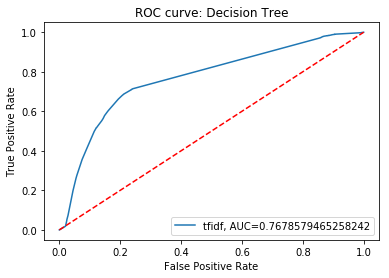

In [42]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="tfidf, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: Decision Tree')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3.7 Top 25 words

In [43]:
words = tf_idf_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_25 = likelihood_df.sort_values(by='Score',ascending=False).iloc[:25]
top_25.reset_index(inplace=True)
top_words = top_25['index']
print(top_words)

0          great
1           best
2           love
3     disappoint
4         delici
5        perfect
6           good
7        favorit
8          excel
9        thought
10           bad
11          nice
12          easi
13       horribl
14          tast
15      unfortun
16         howev
17         worst
18        return
19         would
20       terribl
21         money
22       product
23         least
24           tri
Name: index, dtype: object




Word Cloud for Important features


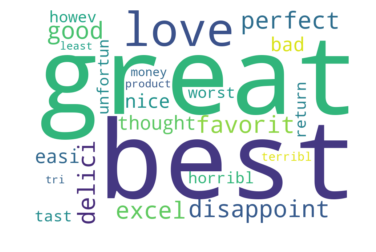

In [44]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(top_words)

wc = WordCloud(background_color="white", max_words=len(top_words), 
               width=900, height=600, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3.8 Visualizing Decision tree By graph

In [45]:
from IPython.display import Image 
from sklearn.tree import export_graphviz
from io import StringIO
from sklearn import tree
import pydotplus
target = ['1','0']  #1=positive,o=negative
dot_data = StringIO()
export_graphviz(clf,max_depth=3,out_file=dot_data,filled=True,class_names=target,feature_names=tf_idf_vect.get_feature_names(),rounded=True,special_characters=True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#show graph
Image(graph.create_png())
# Create PNG
graph.write_png("tfidf.png")



True

## 4. WORD2VEC

In [46]:
from gensim.models import Word2Vec
# List of sentence in X_train text
sent_of_train=[]
for sent in x_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in x_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  12829


## 5.  Avg Word2Vec


In [47]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

## 5.1 Replacing nan values with 0's.


In [48]:
# Replacing nan values with 0's.
train_vectors = np.nan_to_num(train_vectors)
test_vectors = np.nan_to_num(test_vectors)

## 5.2 Standardizing Data

In [49]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler().fit_transform(train_vectors)
print(standardized_data_train.shape)
standardized_data_test = StandardScaler().fit_transform(test_vectors)
print(standardized_data_test.shape)

(105000, 50)
(45000, 50)


## 5.3 Applying Decision Tree Algorithm


In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

param_grid = {'max_depth': [3,4,5,6,7,8,9,10,11]}
model = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=5,criterion = 'gini',random_state = 100,class_weight ='balanced'), param_grid,scoring ='f1',cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print(model.best_score_, model.best_params_) 
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))

a = model.best_params_
optimal_max_depth = a.get('max_depth')

0.855054268929336 {'max_depth': 11}
Model with best parameters :
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=11, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')
Accuracy of the model :  0.8511017957287714


In [51]:
results = model.cv_results_
results['mean_test_score']

array([0.82577276, 0.80860693, 0.8262064 , 0.83612522, 0.83549092,
       0.83680032, 0.84084137, 0.84920992, 0.85505427])

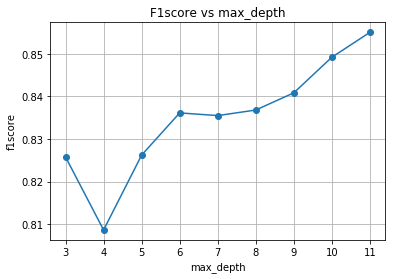

In [52]:
max_depth=3,4,5,6,7,8,9,10,11
plt.plot(max_depth,results['mean_test_score'],marker='o')
plt.xlabel('max_depth')
plt.ylabel('f1score')
plt.title("F1score vs max_depth")
plt.grid()
plt.show()

## Heatmap for plotting CV Scores

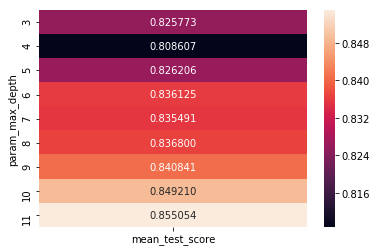

In [53]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score',index='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [54]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth=optimal_max_depth,class_weight ='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)


## 5.4 Confusion Matrix

Confusion Matrix:


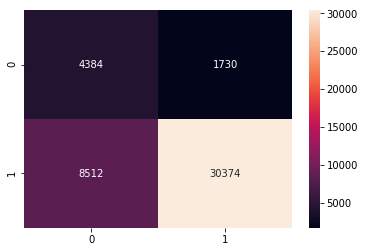

In [55]:
cm_avgw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [56]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4384 
 false positives are 1730 
 false negatives are 8512
 true positives are 30374 
 


## 5.5 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [57]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the Decision tree for maxdepth is = %.3f is %f%%' % (optimal_max_depth, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error of the Decision tree for maxdepth is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the Decision tree for maxdepth is = %.3f is %f' % (optimal_max_depth, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the Decision tree for maxdepth is = %.3f is %f' % (optimal_max_depth, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the Decision tree for maxdepth is \n\n ',(classification_report))


The Test Accuracy of the Decision tree for maxdepth is = 11.000 is 77.240000%

Test Error of the Decision tree for maxdepth is  22.760000%

The Test Precision of the Decision tree for maxdepth is = 11.000 is 0.946113

The Test Recall of the Decision tree for maxdepth is = 11.000 is 0.781104

The Test classification report of the Decision tree for maxdepth is 

                precision    recall  f1-score   support

           0       0.34      0.72      0.46      6114
           1       0.95      0.78      0.86     38886

   micro avg       0.77      0.77      0.77     45000
   macro avg       0.64      0.75      0.66     45000
weighted avg       0.86      0.77      0.80     45000



## 5.6 Plotting roc_auc curve

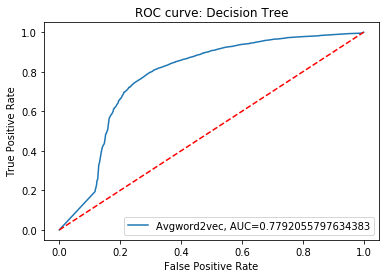

In [58]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Avgword2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: Decision Tree')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5.7 Visualizing Decision tree By graph

In [59]:
from IPython.display import Image 
from sklearn.tree import export_graphviz
from io import StringIO
from sklearn import tree
import pydotplus
target = ['1','0']  #1=positive,o=negative
dot_data = StringIO()
export_graphviz(clf,max_depth=3,out_file=dot_data,filled=True,class_names=target,rounded=True,special_characters=True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#show graph
Image(graph.create_png())
# Create PNG
graph.write_png("Avgword2vec.png")




True

## 6. TFIDF-Word2Vec

In [60]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect = TfidfVectorizer()
final_counts_tfidfw2v_train= tfidfw2v_vect.fit_transform(x_train) 
print(type(final_counts_tfidfw2v_train))
print(final_counts_tfidfw2v_train.shape)

final_counts_tfidfw2v_test= tfidfw2v_vect.transform(x_test) 
print(type(final_counts_tfidfw2v_test))
print(final_counts_tfidfw2v_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(105000, 38300)
<class 'scipy.sparse.csr.csr_matrix'>
(45000, 38300)


In [61]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidfw2v_vect.get_feature_names(), list(tfidfw2v_vect.idf_)))


# TF-IDF weighted Word2Vec
tfidf_feat = tfidfw2v_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

#Test case

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors1))

105000
45000


## 6.1 Replacing nan values with 0's.


In [62]:
# Replacing nan values with 0's.
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)
tfidf_sent_vectors1 = np.nan_to_num(tfidf_sent_vectors1)

## 6.2 Standardizing the data

In [63]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data_train.shape)
standardized_data_test = StandardScaler().fit_transform(tfidf_sent_vectors1)
print(standardized_data_test.shape)

(105000, 50)
(45000, 50)


## 6.3 Applying Decision Tree Algorithm

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

param_grid = {'max_depth': [3,4,5,6,7,8,9,10,11]}
model = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=5,criterion = 'gini',random_state = 100,class_weight ='balanced'), param_grid,scoring = 'f1', cv=10 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print(model.best_score_, model.best_params_) 
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))

a = model.best_params_
optimal_max_depth = a.get('max_depth')

0.8354360328739859 {'max_depth': 11}
Model with best parameters :
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=11, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')
Accuracy of the model :  0.8336079549525024


In [65]:
results = model.cv_results_
results['mean_test_score']

array([0.79726993, 0.81114502, 0.80925418, 0.80716328, 0.81980523,
       0.82280966, 0.82789968, 0.83054522, 0.83543603])

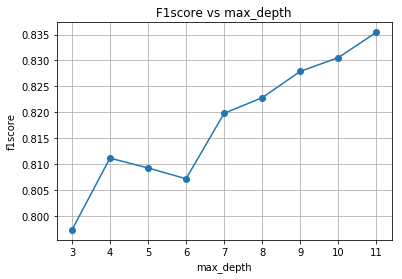

In [66]:
max_depth=3,4,5,6,7,8,9,10,11
plt.plot(max_depth,results['mean_test_score'],marker='o')
plt.xlabel('max_depth')
plt.ylabel('f1score')
plt.title("F1score vs max_depth")
plt.grid()
plt.show()

## Heatmap for plotting CV Scores

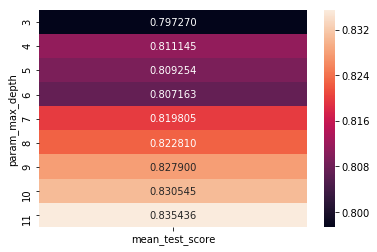

In [67]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score',index='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [68]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth=optimal_max_depth,class_weight ='balanced')
clf.fit(standardized_data_train,y_train)
y_pred_tfidfw2v = clf.predict(standardized_data_test)

## 6.4 Confusion Matrix

Confusion Matrix:


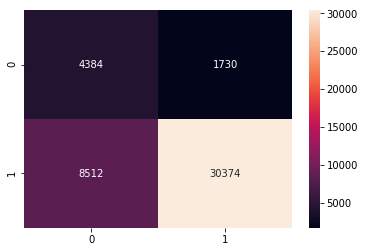

In [69]:
cm_tfidfw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [70]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4384 
 false positives are 1730 
 false negatives are 8512
 true positives are 30374 
 


## 6.5 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report


In [71]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the Decision tree for maxdepth is = %.3f is %f%%' % (optimal_max_depth, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error of the Decision tree for maxdepth is  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the Decision tree for maxdepth is = %.3f is %f' % (optimal_max_depth, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the Decision tree for maxdepth is = %.3f is %f' % (optimal_max_depth, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the Decision tree for maxdepth is \n\n ',(classification_report))


The Test Accuracy of the Decision tree for maxdepth is = 11.000 is 77.240000%

Test Error of the Decision tree for maxdepth is  22.760000%

The Test Precision of the Decision tree for maxdepth is = 11.000 is 0.946113

The Test Recall of the Decision tree for maxdepth is = 11.000 is 0.781104

The Test classification report of the Decision tree for maxdepth is 

                precision    recall  f1-score   support

           0       0.34      0.72      0.46      6114
           1       0.95      0.78      0.86     38886

   micro avg       0.77      0.77      0.77     45000
   macro avg       0.64      0.75      0.66     45000
weighted avg       0.86      0.77      0.80     45000



## 6.6 Visualizing Decision tree By graph

In [72]:
from IPython.display import Image 
from sklearn.tree import export_graphviz
from io import StringIO
from sklearn import tree
import pydotplus
target = ['1','0']  #1=positive,o=negative
dot_data = StringIO()
export_graphviz(clf,max_depth=3,out_file=dot_data,filled=True,class_names=target,rounded=True,special_characters=True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# Show graph
Image(graph.create_png())
# Create PNG
graph.write_png("tfidfword2vec.png")


True

For Avgword2vec and TFidfword2vec we cannot print featurenames(we cannot calculate feature imporatances)

## 7. Conclusion

-----------------------------------------------------------------------------------------------------------------------
|
  Model Performance Table                                                                                                       

-----------------------------------------------------------------------------------------------------------------------
|           Model                    |       Depth                          | criterion    | Test Error   | Accuracy  |
|:----------------------------------:|:------------------------------------:|:------------:|:------------:|:---------:|
| Decision Tree with Bow             |         11                           |   gini       |28.784444     |71.215556  |
| Decision Tree with Tfidf           |         11                           |   gini       |20.966667     |70.033333  |
| Decision Tree with Avgw2v          |         11                           |   gini       |22.760000     |77.240000  |
| Decision Tree with Tfidfw2v        |         11                           |   gini       |22.760000     |77.240000  |

-----------------------------------------------------------------------------------------------------------------------

Steps Involved:-

1) Connecting SQL file

2) Data Preprocessing(Already i had done preprocessing no need to do again)

3) Sorting the data based on time

4) Taking 1st 150K Rows (Due to low Ram)

5) Spliting data into train and test based on time (70:30)

6) Techniques For Vectorization Bow,TF-IDF,word2vec,Avgword2vec,tfidfword2vec.

7) Replacing nan values with 0's

8) standardizing Data 

9) Applying Decision Tree Algorithm

9) Plotted a graph between f1score vs max_depth

10) Introduced heatmap for cv_results vs max_deth

10) I calculated Accuracy,Error on Test Data, Confusion Matrix,Precision Score,Recall Score,Classification Report,ROC_curve

11) Calculated top features and builded a word cloud

12) I calculated Accuracy,Error on Test Data, Confusion Matrix,Precision Score,Recall Score,Classification Report,ROC_curve

13) Visualizing Decision Tree By Graph

14) Conclusion